## Pump it Up: Data Mining the Water Table- Project#3

* Student name: ***Deepali Sharma***
* Student pace: ***Flex***
* Scheduled project review date/time: ***January, 2023***
* Instructor name: ***Abhineet Kulkarni***

## Modeling

1. The data was split into training and test sets.
2. The data was pre-processed. 
3. Several types of classifiers were built, tuned (using GridSearchCV to test combinations of hyperparameters) and validated:

    - Logistic Regression
    - Decision Tree
    - Random Forest
    - XGradient Boosted
    - Stacking Classifier (using above models)


## Evaluation

4. Roc_Auc and f-score were used was used as the scoring metric for tuning hyperparameters and evaluating model performance. 

    * The Roc_Auc metric utilizes **"probabilities"** of class prediction. Based on that, we’re able to more precisely evaluate and compare the models.
    * We also care equally about positive and negative classes, and the roc curve gives a desirable balance between **sensitivity/recall (maximizing True positive Rate)** and and **1 - specificity (minimizing False Positive Rate -Probability that a true negative will test positive)**.
    * Our focus is not just good predictions, but we want to delve deeper and understand feature importance and model characteristics. Because of this we will check out metrics on both train and test set

In [1]:
import os, sys, time
print(sys.executable)

/usr/local/anaconda3/bin/python


In [167]:
%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [251]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
#pd.set_option('display.max_rows', 10)
import seaborn as sns
#sns.set_style("whitegrid")
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as mticker
import missingno as mssno

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.dummy import DummyClassifier


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import plot_confusion_matrix # plot_confusion_matrix is a visual tool added in the latest version of scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix # if you are running an older version, use confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline # You need imblearn Pipeline for Smote work in a Pipeline
from itertools import cycle


import warnings
warnings.filterwarnings("ignore")
#%load_ext autotime

time: 2.92 ms (started: 2023-01-03 12:29:36 -05:00)


In [3]:
from xgboost import XGBClassifier

In [4]:
df_data = pd.read_csv("Data_train.csv")
df_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
df_labels = pd.read_csv("Data_train_labels.csv")
df_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
df = pd.merge(df_data,df_labels,how='inner',left_on='id', right_on='id')
df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


## Data Exploration and Cleaning

In [7]:
df.duplicated().sum()

0

* Creating a temporary data frame to explore various variables and see what columns can be dropped, check for correlations, null values, and any other features. To look at the categorical columns, I will use cat.codes and plot in seaborn

In [8]:
df_ana=df
df_ana=df_ana.drop('id',axis=1)

In [9]:
data_cat = df_ana
data_cat = data_cat.apply(lambda x: x.astype('category').cat.codes)

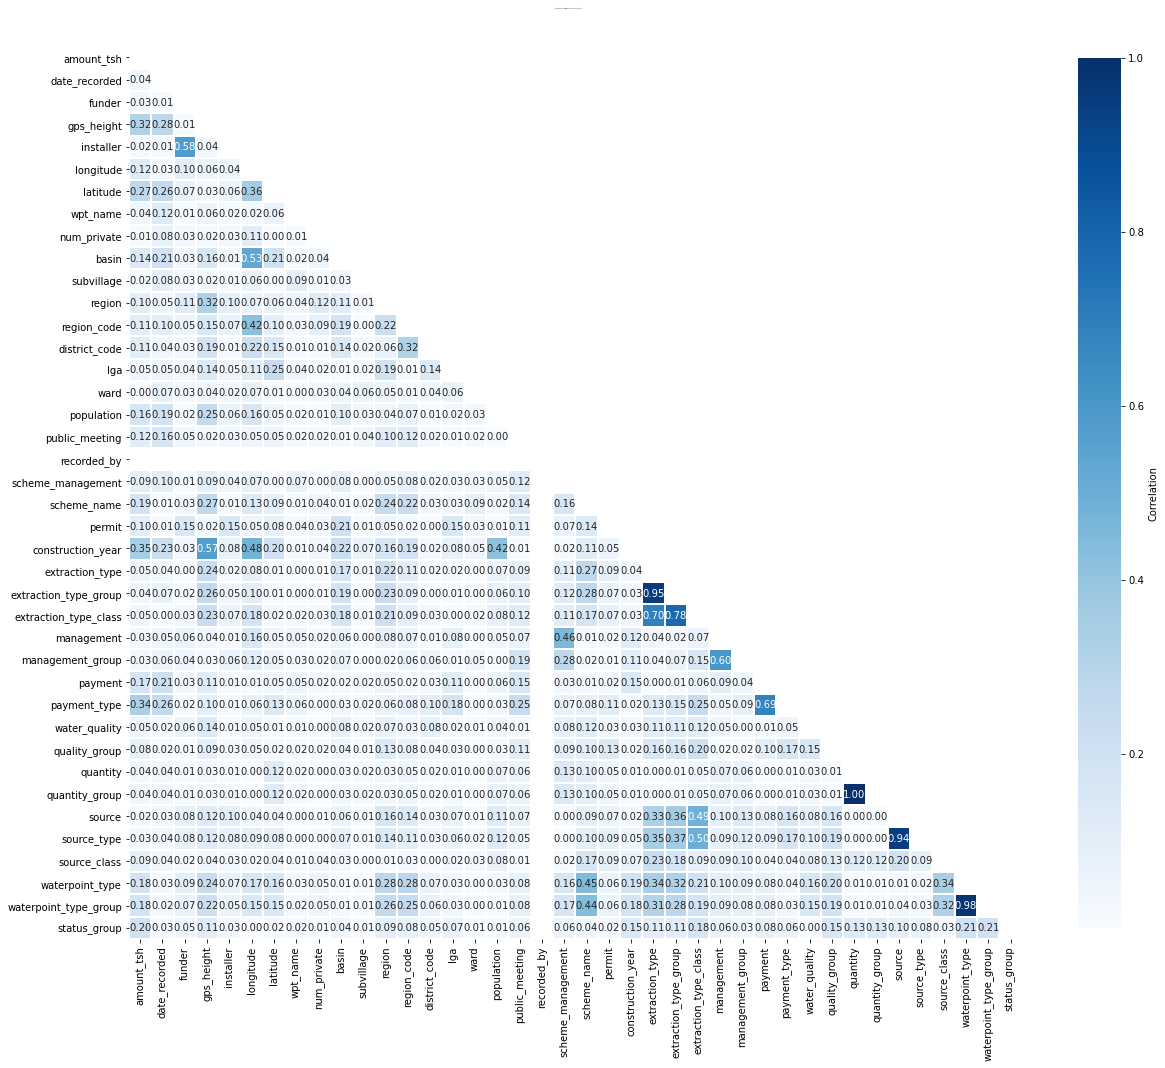

In [10]:
corr = data_cat.corr().abs()

fig, ax=plt.subplots(figsize=(20,20))
matrix = np.triu(corr) # Getting the Upper Triangle of the correlation matrix
cbar_kws={"label": "Correlation", "shrink":0.8}
heatmap = sns.heatmap(data = corr, cmap='Blues', linewidths = 1, square= True,  ax=ax, annot=True, mask=matrix, fmt= ".2f", cbar_kws=cbar_kws) 
fig.suptitle('Heatmap of Correlation Between All Variables (Including Target)', fontsize=1, y=.84, x = .43, fontname='Arial');
heatmap;

* we will drop the columns that have correlations above 0.9. Also lets explore the null values for each column. Many columns are just duplicates and contain repetitive information and hence show high correlations

In [11]:
df_ana=df_ana.drop(columns=['num_private','waterpoint_type_group','scheme_name',\
                           'extraction_type_group','quantity_group',\
                            'source_type','payment_type','quality_group'
                           ],axis=1)

In [12]:
df_ana.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 32 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
recorded_by              59400 non-null object
scheme_management        55523 non-null object

In [13]:
nulls = ((df.isnull().sum()*100) / len(df)).sort_values(ascending=False)
nulls[nulls > 0]

scheme_name          47.417508
scheme_management     6.526936
installer             6.153199
funder                6.119529
public_meeting        5.612795
permit                5.144781
subvillage            0.624579
dtype: float64

* **scheme_name** has about 47% missing values. So I will drop it for now. I will come back and try using "missing" instead and see if their is any model improvement. Lets look at the correlation again

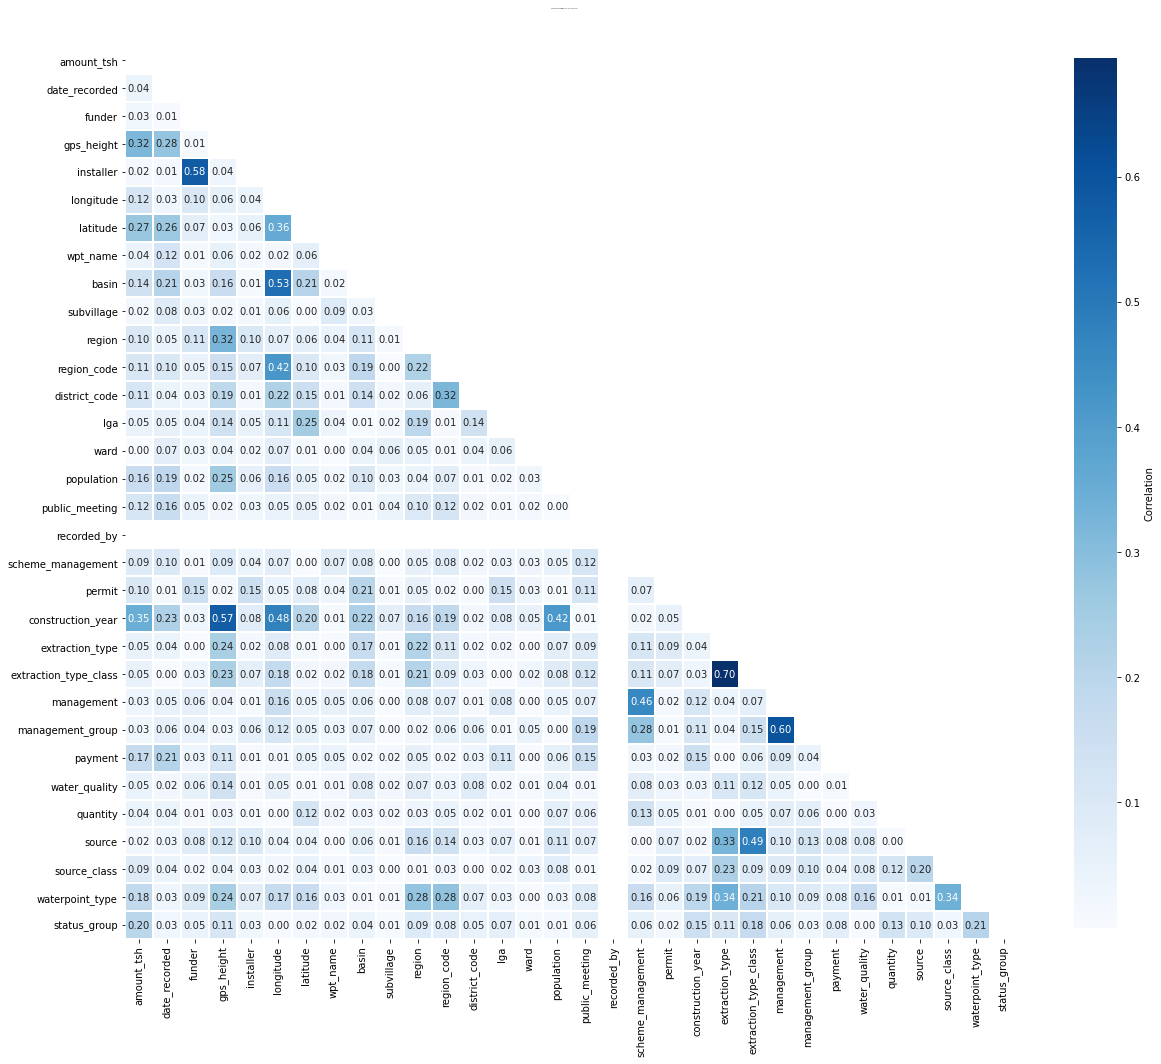

In [14]:
data_cat = df_ana
data_cat = data_cat.apply(lambda x: x.astype('category').cat.codes)
corr = data_cat.corr().abs()
fig, ax=plt.subplots(figsize=(20,20))
matrix = np.triu(corr) # Getting the Upper Triangle of the correlation matrix
cbar_kws={"label": "Correlation", "shrink":0.8}
heatmap = sns.heatmap(data = corr, cmap='Blues', linewidths = 1, square= True,  ax=ax, annot=True, mask=matrix, fmt= ".2f", cbar_kws=cbar_kws) 
fig.suptitle('Heatmap of Correlation Between All Variables (Including Target)', fontsize=1, y=.84, x = .43, fontname='Arial');
heatmap;

In [15]:
df_ana.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [16]:
df_ana.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

* **extraction_type_class and **extraction_type** have correlation of 0.7. Since extraction_type has more detailed values, I will keep this column and drop class column

In [17]:
df_ana= df_ana.drop("extraction_type_class",axis=1)

In [18]:
#data_cat.hist(bins='auto', edgecolor='none', figsize=(16,16));

* **Amount_tsh** which corresponds to the static head meaning water above certain level that is a measure of how much water can be drawn. A huge fraction of data has 0 for this variable. This could be that it corresponds to open reservoirs 

In [19]:
nulls = ((df_ana.isnull().sum()*100) / len(df_ana)).sort_values(ascending=False)
nulls[nulls > 0]

scheme_management    6.526936
installer            6.153199
funder               6.119529
public_meeting       5.612795
permit               5.144781
subvillage           0.624579
dtype: float64

* Lets look at the missing values distribution and see if we see any patterns. We will use missingno library for these

<AxesSubplot:>

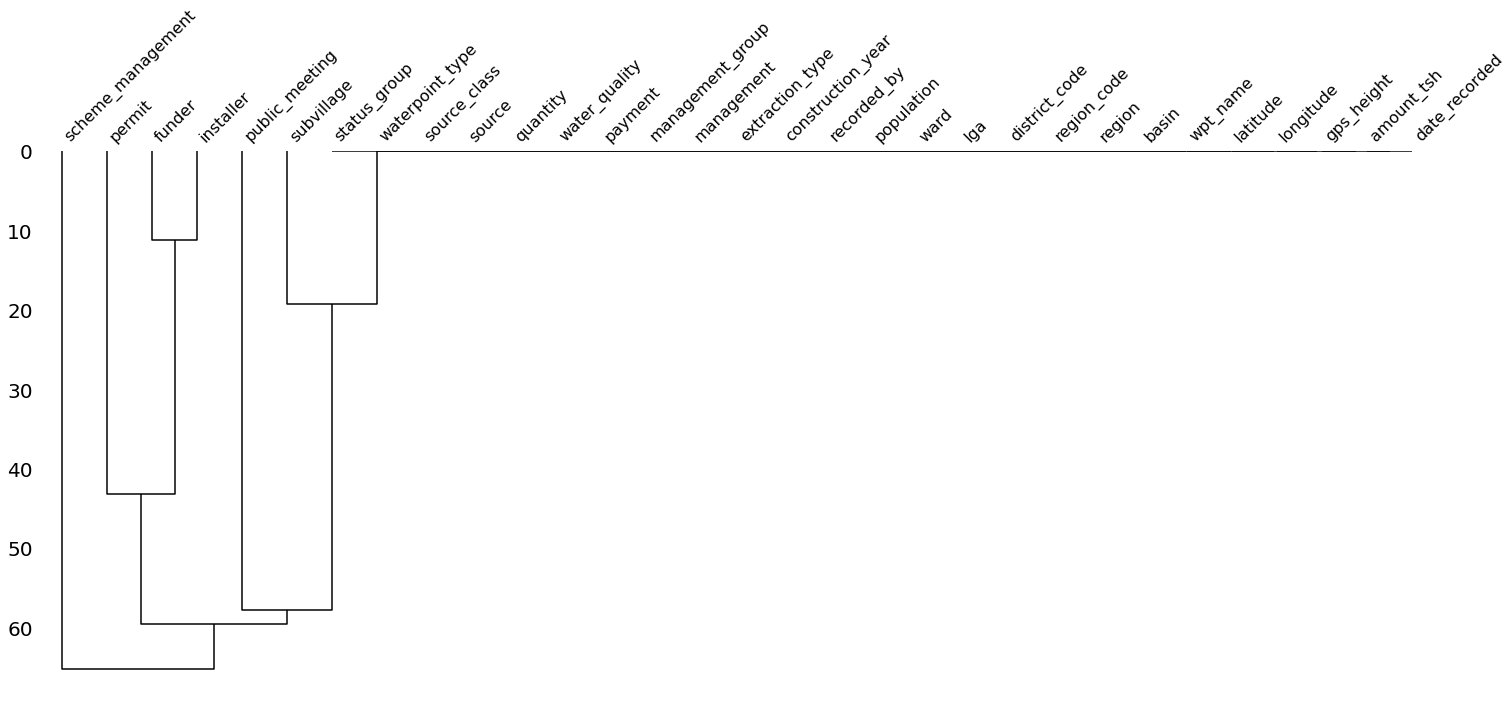

In [20]:
#mssno.heatmap(data_cat)
mssno.dendrogram(df_ana)

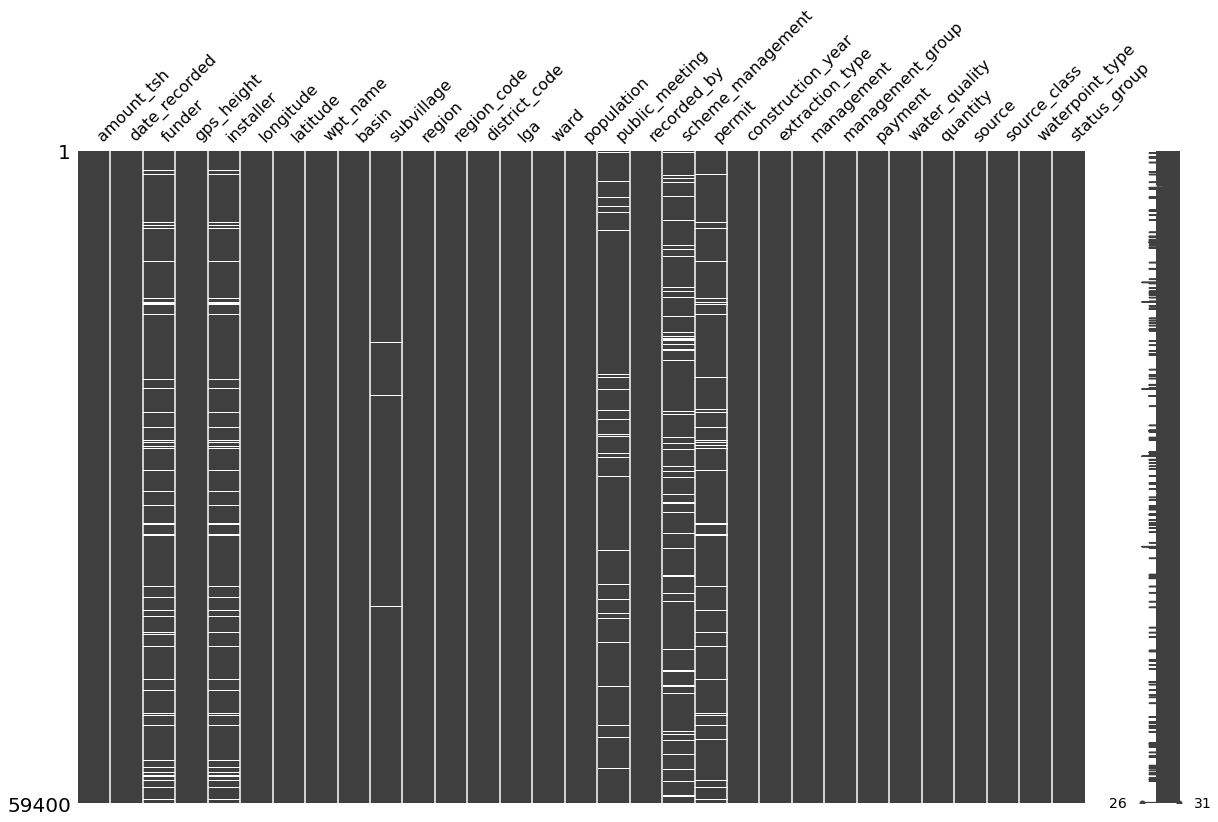

In [21]:
#import missingno as mssno
mssno.matrix(df_ana, figsize=(20, 12));

* Both are installer and funder almost always show missing values corresponding to same rows. 

In [22]:
#len(df_ana[['funder','installer','permit','public_meeting','scheme_management']]\
#    [(df_ana.isnull().sum(axis=1) >= 4)])/len(df_ana)*100

In [23]:
df_ana.shape

(59400, 31)

In [84]:
#df_clean = df_ana.drop(df_ana[(df_ana.isnull().sum(axis=1) >= 4)].index, axis=0)
#df_clean.shape
df_clean = df_ana
df_clean.shape

(59400, 34)

* We only loose 0.3% data after removing the rows with 4 or more missing values


<AxesSubplot:>

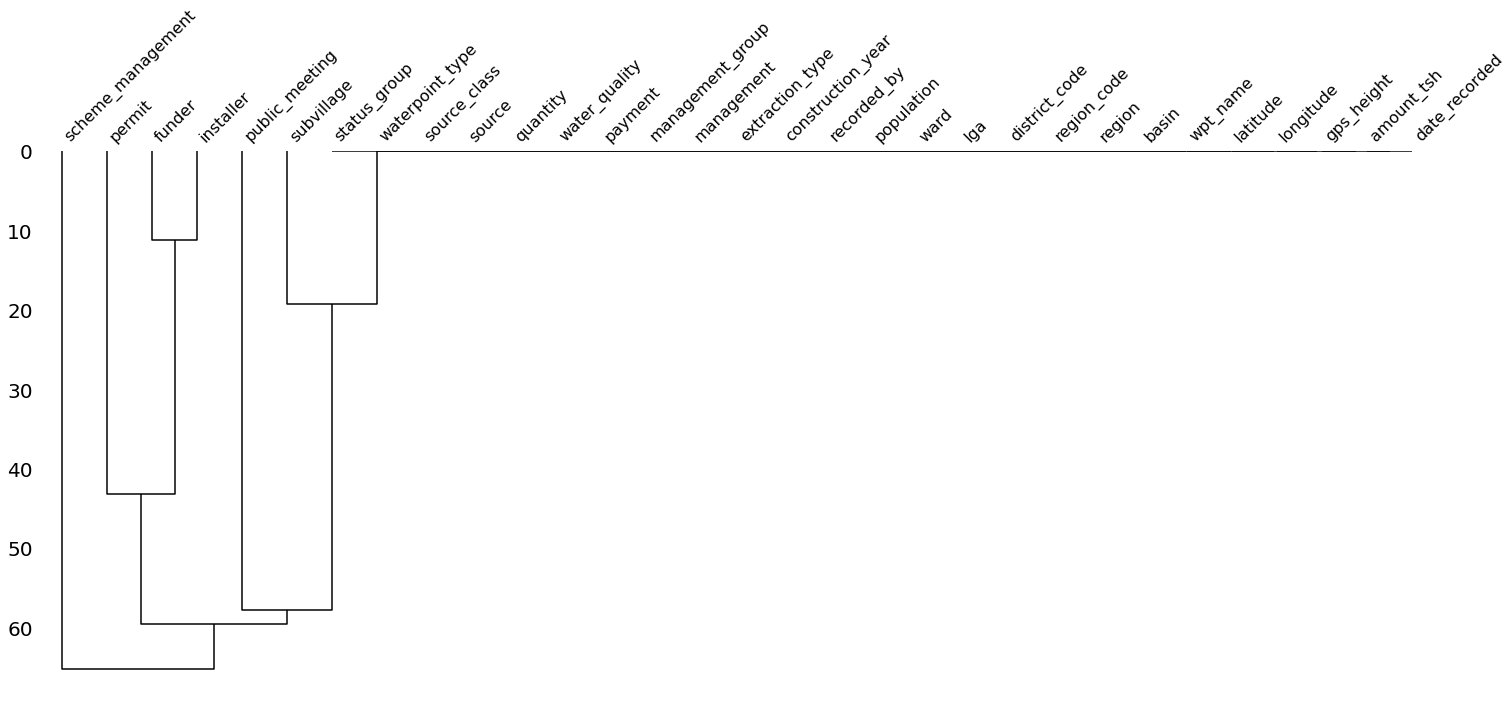

In [27]:
mssno.dendrogram(df_clean)#, figsize=(10, 10));

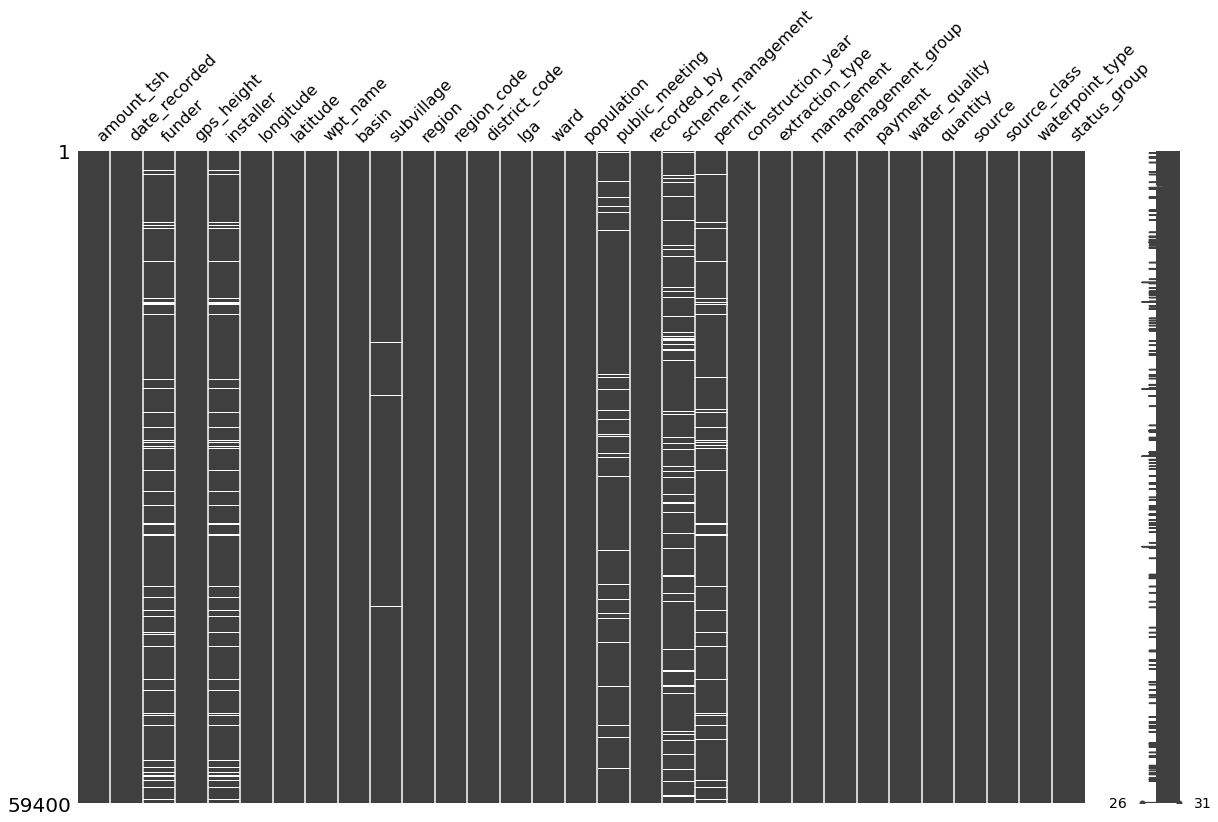

In [28]:
mssno.matrix(df_clean, figsize=(20, 12));

In [29]:
nulls = ((df_clean.isnull().sum()*100) / len(df_clean)).sort_values(ascending=False)
nulls[nulls > 0]

scheme_management    6.526936
installer            6.153199
funder               6.119529
public_meeting       5.612795
permit               5.144781
subvillage           0.624579
dtype: float64

In [85]:
df_clean.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['gps_height', 'region_code', 'district_code', 'population',
        'construction_year'],
       dtype='object'),
 dtype('float64'): Index(['amount_tsh', 'longitude', 'latitude'], dtype='object'),
 dtype('O'): Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
        'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
        'scheme_management', 'permit', 'extraction_type', 'management',
        'management_group', 'payment', 'water_quality', 'quantity', 'source',
        'source_class', 'waterpoint_type', 'status_group'],
       dtype='object')}

In [86]:
df_ana['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

* I am converting **status_group** column to an integer for plotting purposes and group the data according to this category

In [87]:
df_play = df_clean.copy()
dic = {'functional':0, 'non functional':1,'functional needs repair':2 }
df_play.replace({"status_group": dic}, inplace=True)
df_play["status_group"].value_counts()

0    32259
1    22824
2     4317
Name: status_group, dtype: int64

In [88]:
df_ana['permit'].isna().sum()

3056

In [89]:
df_ana['public_meeting'].isna().sum()

3334

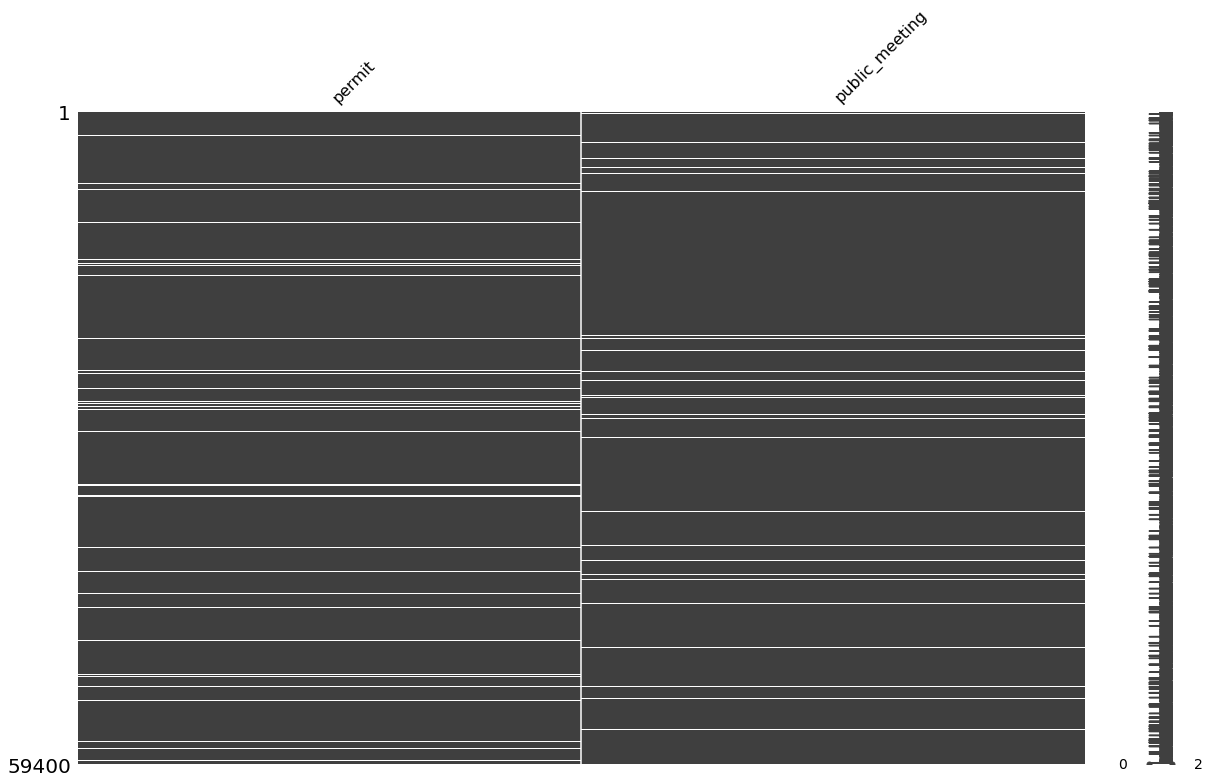

In [90]:
mssno.matrix(df_ana[['permit','public_meeting']], figsize=(20, 12));

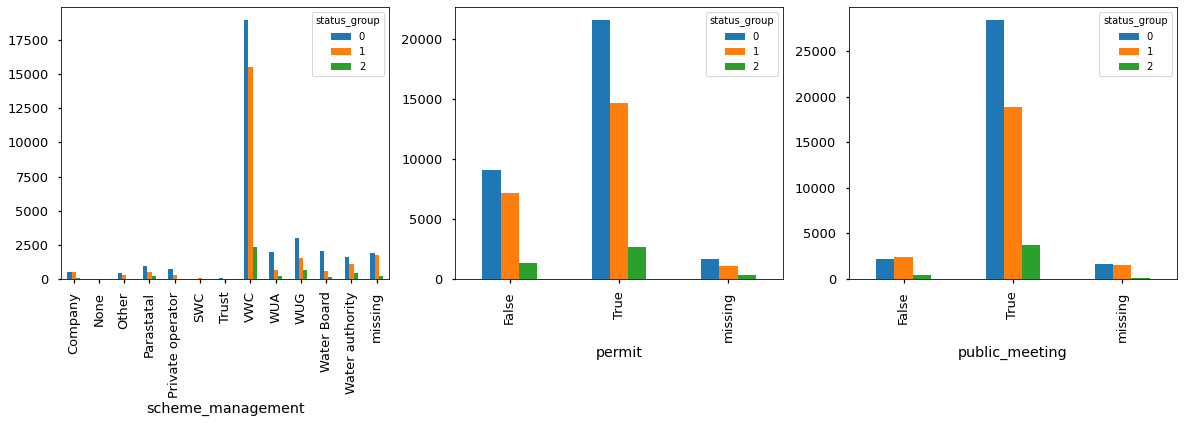

In [91]:
vars = ['scheme_management', 'permit', 'public_meeting']

with plt.style.context('seaborn-talk'):
    fig, ax_list = plt.subplots(ncols = 3, figsize=(20,5))  
    
for i in [0,1,2]:
    df_play[vars[i]] = df_play[vars[i]].fillna('missing')
    counts = df_play[['status_group',vars[i]]].groupby(['status_group',vars[i]]).size().unstack('status_group')
    counts.plot.bar(ax=ax_list[i])
        

* There does not seem any difference in the relative proportions for pump status  and "permit, public_meeting, scheme mangaement".

In [37]:
def get_and_plot_groups(df, col_to_study,col_to_group,ax=None, Flen=10, Fhgt=5,orient=None):
    df_new = pd.DataFrame(df[[col_to_study,col_to_group]]\
                      .groupby([col_to_study,col_to_group])\
                      .agg(({col_to_group: ['count']})))
    df_new.columns = ['_'.join(col) for col in df_new.columns.values]
    df_new   = df_new.reset_index()
    sorteddf = df_new.sort_values(df_new.columns[2], ascending=False)
    sorteddf.head()
    fig, ax = plt.subplots(figsize=(Flen,Fhgt))
    if (orient==None):
        ax      = sns.barplot(x=df_new.columns[0], y=df_new.columns[2],data=sorteddf,\
                    hue=df_new.columns[1],orient=orient)
    elif orient=='h':
        ax      = sns.barplot(x=df_new.columns[2], y=df_new.columns[0],data=sorteddf,\
                    hue=df_new.columns[1],orient='h')
    ax.legend(loc='upper right')

## Feature Engineering
* I want to create an **age** variable based on the **construction_year** information. However, a large subset of data has **0** for construction_year. So I will assign it as 60 under the assumption that those wells construction date is unknown and most likely predates 1960 which is the earliest recorded year in this dataset. Also the latest year is 2013. So I define age from 2014.

In [92]:
df_clean['construction_year'][df_clean['construction_year']>2013].value_counts()

Series([], Name: construction_year, dtype: int64)

* Also lets look at the **recorded_year**. I am going to generate recorded year and month as two new columns

In [93]:
#df_clean['date_recorded']
#pd.to_datetime(df_clean['date']).dt.year
from datetime import date
from datetime import datetime
df_clean['date_recorded']=pd.to_datetime(df_clean['date_recorded'])
df_clean['yr_record']=df_clean['date_recorded'].dt.year.astype('int')
df_clean['month_record']=df_clean['date_recorded'].dt.month.astype('int')
#df['age'] =df['yr_sold']-df['yr_built']
df_clean[['date_recorded','yr_record','month_record']]

,date_recorded,yr_record,month_record
0,2011-03-14,2011,3
1,2013-03-06,2013,3
2,2013-02-25,2013,2
3,2013-01-28,2013,1
4,2011-07-13,2011,7
...,...,...,...
59395,2013-05-03,2013,5
59396,2011-05-07,2011,5
59397,2011-04-11,2011,4
59398,2011-03-08,2011,3


In [94]:
df_clean['yr_record'].value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: yr_record, dtype: int64

In [95]:
#mask = df_clean['constructed_year'] != 0 # create a mask for those rows with a value in yr_renovated.
#df_clean.loc[mask, "age"] = (2014 - df_clean['constructed_year'])
#df_clean['age']=df_clean['construction_year'].apply(lambda x: (2014 - df_clean['construction_year']) if x!=0 else x)
#df_clean['age'] = df.construction_year.map( lambda x: (2014 - df_clean['construction_year']) if x != '0' else x)
df_clean['age'] = (2014 - df_clean['construction_year'])

In [96]:
df_clean['age'] = df_clean['age'].replace(2014, 60)

In [97]:
#df_clean.age.value_counts()

* I will bin the age in 5 years bins

In [98]:
conditions = [
    (df_clean['age'] <=5),
    (df_clean['age'] > 5) & (df_clean['age'] <= 10),
    (df_clean['age'] > 10) & (df_clean['age'] <= 15),
    (df_clean['age'] > 15) & (df_clean['age'] <= 20),
    (df_clean['age'] > 20) & (df_clean['age'] <= 25),
    (df_clean['age'] > 25) & (df_clean['age'] <= 30),
    (df_clean['age'] > 30) & (df_clean['age'] <= 35),
    (df_clean['age'] > 35) & (df_clean['age'] <= 40),
    (df_clean['age'] > 40) & (df_clean['age'] <= 45),
    (df_clean['age'] > 45) & (df_clean['age'] <= 50),
    (df_clean['age'] > 50) & (df_clean['age'] <= 55),
    (df_clean['age'] > 5) & (df_clean['age'] <= 60),
     ]
choices =[5,10,15,20,25,30,35,40,45,50,55,60]

In [99]:
df_clean['age'] = np.select(conditions,choices, default=0)

In [100]:
df_clean['age'].value_counts()
#df_clean['age']=df_clean[df_clean.age]

60    20709
10     7805
5      7694
15     5971
20     4173
30     2981
25     2842
40     2766
35     2473
45     1507
50      241
55      238
Name: age, dtype: int64

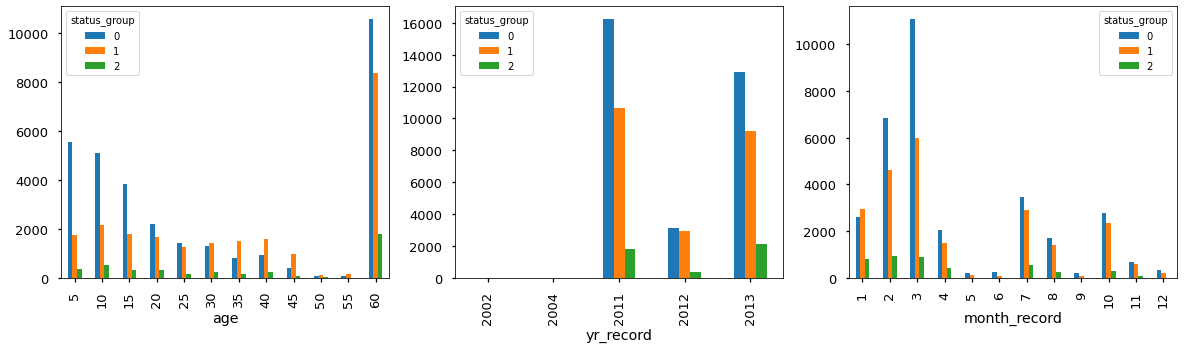

In [101]:
df_play = df_clean.copy()
dic = {'functional':0, 'non functional':1,'functional needs repair':2 }
df_play.replace({"status_group": dic}, inplace=True)
df_play["status_group"].value_counts()
vars = ['age', 'yr_record', 'month_record']

with plt.style.context('seaborn-talk'):
    fig, ax_list = plt.subplots(ncols = 3, figsize=(20,5))  
    
for i in [0,1,2]:
    df_play[vars[i]] = df_play[vars[i]].fillna('missing')
    counts = df_play[['status_group',vars[i]]].groupby(['status_group',vars[i]]).size().unstack('status_group')
    counts.plot.bar(ax=ax_list[i])
        

In [102]:
#fig, ax = plt.subplots(figsize=(8, 6))
#base_color = sns.color_palette("husl", 9)[6]
#sns.regplot(x="age", y="yr_record", ax=ax, data=df_play, color = base_color, line_kws={"color": "orange"})
#print(df_play.corr()['yr_record']['age'])


* We see the obvious corrections between the reconstructed varibles and the ones from which they were reconstructed. So we will drop **date_recorded** and **construction_year** from the dataset

In [104]:
df_clean=df_clean.drop(['construction_year','date_recorded'],axis=1)

In [105]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 32 columns):
amount_tsh           59400 non-null float64
funder               55765 non-null object
gps_height           59400 non-null int64
installer            55745 non-null object
longitude            59400 non-null float64
latitude             59400 non-null float64
wpt_name             59400 non-null object
basin                59400 non-null object
subvillage           59029 non-null object
region               59400 non-null object
region_code          59400 non-null int64
district_code        59400 non-null int64
lga                  59400 non-null object
ward                 59400 non-null object
population           59400 non-null int64
public_meeting       56066 non-null object
recorded_by          59400 non-null object
scheme_management    55523 non-null object
permit               56344 non-null object
extraction_type      59400 non-null object
management           59400 non-n

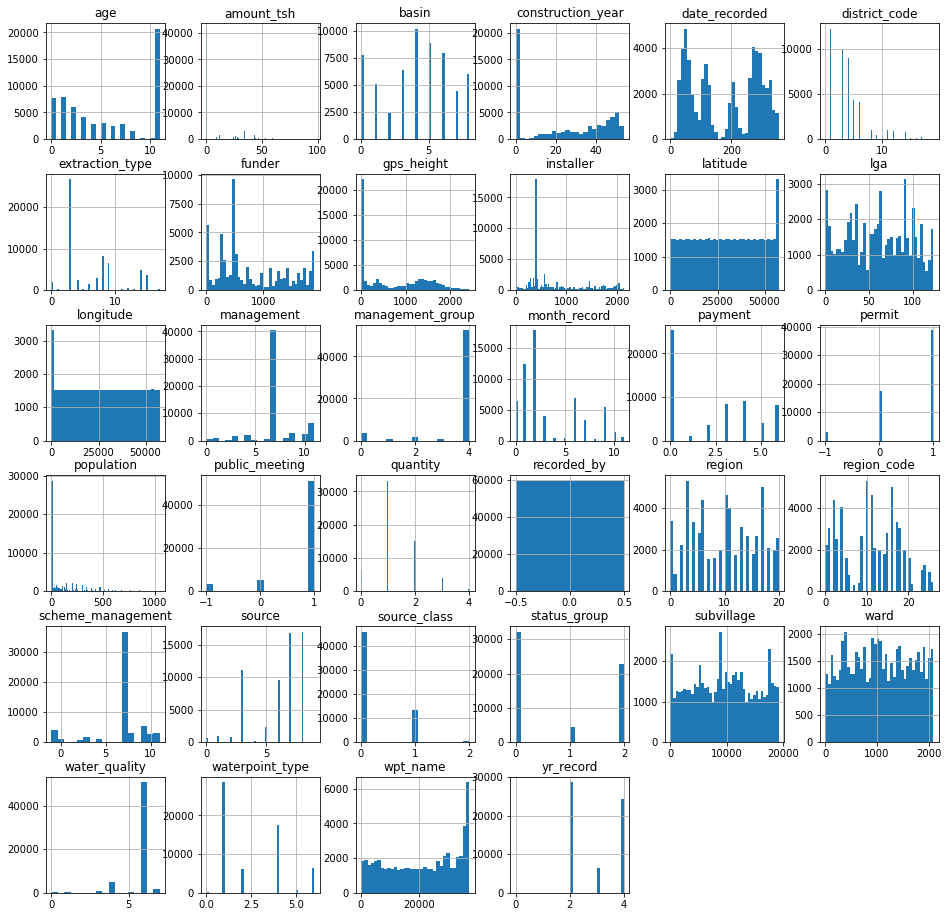

In [106]:
data_cat.hist(bins='auto', edgecolor='none', figsize=(16,16));

* **Amount_tsh** which corresponds to the static head meaning water above certain level that is a measure of how much water can be drawn. A huge fraction of data has 0 for this variable. This could be that it corresponds to open reservoirs 

In [52]:
nulls = ((df_clean.isnull().sum()*100) / len(df_clean)).sort_values(ascending=False)
nulls[nulls > 0]

scheme_management    6.526936
installer            6.153199
funder               6.119529
public_meeting       5.612795
permit               5.144781
subvillage           0.624579
dtype: float64

In [52]:
df_clean["status_group"].value_counts(normalize=True)

functional                 0.543450
non functional             0.383782
functional needs repair    0.072768
Name: status_group, dtype: float64

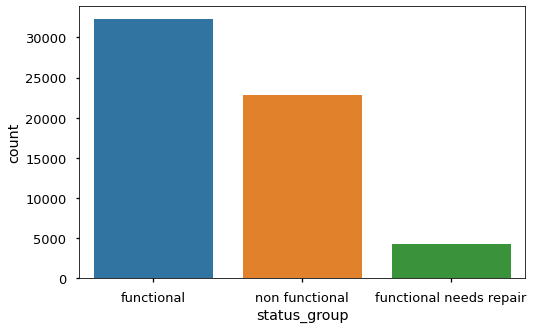

In [53]:
with plt.style.context('seaborn-talk'):
    fig, ax1 = plt.subplots(figsize=(8, 5))
    sns.countplot(df_clean['status_group'], ax= ax1);

In [107]:
df_clean=df_clean.drop('recorded_by',axis=1)

* There are a lot of similar values for installer and funder columns. In the functions below I am going to combine similar values to generalized values

In [108]:
def clean_installer(df):

    df['installer'] = df['installer'].astype(str).str.lower()
    df['installer'].replace(
        to_replace=(
            'fini water', 'fin water', 'finn water', 'finwater', 'finwate'),
        value='finw', inplace=True)
    df['installer'].replace(to_replace=('jaica co'), value='jaica', inplace=True)
    df['installer'].replace(
        to_replace=(
            'district water department', 'district water depar', 'district council',
            'district counci', 'village council orpha','kibaha town council',
            'village council', 'coun', 'village counil', 'council',
            'mbulu district council', 'counc', 'village council .oda',
            'sangea district coun', 'songea district coun', 'villege council',
            'district  council', 'quick win project /council', 'mbozi district council',
            'village  council', 'municipal council', 'tabora municipal council',
            'wb / district council'),
        value='council', inplace=True)
    df['installer'].replace(
        to_replace=(
            'rc church', 'rc churc', 'rcchurch/cefa', 'irc', 'rc', 'rc ch', 'hw/rc',
            'rc church/central gover', 'kkkt church', 'pentecost church', 'roman church',
            'rc/mission', 'rc church/cefa', 'lutheran church', 'tag church',
            'free pentecoste church of tanz', 'rc c', 'church', 'rc cathoric',
            'morovian church', 'cefa/rc church', 'rc mission', 'anglican church',
            'church of disciples', 'anglikana church', 'cetral government /rc',
            'pentecostal church', 'cg/rc', 'rc missionary', 'sda church', 'methodist church', 'trc',
            'rc msufi', 'haidomu lutheran church', 'baptist church', 'rc church brother',
            'st magreth church', 'anglica church', 'global resource co', 'rc mi',
            'baptist church of tanzania', 'fpct church', 'rc njoro', 'rc .church',
            'rc mis', 'batist church', 'churc', 'dwe/anglican church','missi', 'mission',
            'ndanda missions', 'rc/mission', 'cvs miss', 'missionaries', 'hydom luthelani',
            'luthe', 'haydom lutheran hospital', 'lutheran', 'missio', 'germany missionary',
            'grail mission kiseki bar', 'missionary', 'heri mission', 'german missionsry',
            'wamissionari wa kikatoriki', 'neemia mission', 'wamisionari wa kikatoriki'),
        value='church', inplace=True)
    df['installer'].replace(
        to_replace=(
            'central government', 'gove', 'central govt', 'gover', 'cipro/government',
            'governme', 'adra /government', 'isf/government', 'adra/government',
            'government /tcrs', 'village govt', 'government', 'government /community',
            'concern /government', 'goverm', 'village government', 'cental government',
            'govern', 'cebtral government', 'government /sda', 'tcrs /government',
            'tanzania government', 'centra govt', 'colonial government', 'misri government',
            'government and community', 'cetral government /rc', 'concern/government',
            'government of misri', 'lwi &central government', 'governmen', 'government/tcrs', 'government /world vision',
            'centra government'),
        value='tanzanian government', inplace=True)
    df['installer'].replace(
        to_replace=(
            'world vission', 'world division', 'word divisio','world visiin'),
        value='world vision', inplace=True)
    df['installer'].replace(to_replace=('unicrf'), value='unicef', inplace=True)
    df['installer'].replace(
        to_replace=(
            'commu', 'olgilai village community', 'adra /community', 'adra/community',
            'rwe/ community', 'killflora /community', 'communit', 'taboma/community',
            'arab community', 'adra/ community', 'sekei village community', 'rwe/community',
            'arabs community', 'village community', 'government /community',
            'dads/village community', 'killflora/ community', 'mtuwasa and community',
            'rwe /community', 'ilwilo community', 'summit for water/community',
            'igolola community', 'ngiresi village community', 'rwe community',
            'african realief committe of ku', 'twesa /community', 'shelisheli commission',
            'twesa/ community', 'marumbo community', 'government and community',
            'community bank', 'kitiangare village community', 'oldadai village community',
            'twesa/community', 'tlc/community', 'maseka community', 'islamic community',
            'district community j', 'village water commission', 'village community members',
            'tcrs/village community', 'village water committee', 'comunity'),
        value='community', inplace=True)
    df['installer'].replace(
        to_replace=(
            'danid', 'danda','danida co', 'danny', 'daniad', 'dannida', 'danids'),
        value='danida', inplace=True)
    df['installer'].replace(
        to_replace=(
            'hesaws', 'huches', 'hesaw', 'hesawz', 'hesawq', 'hesewa'),
        value='hesawa', inplace=True)
    df['installer'].replace(
        to_replace=(
            'dwsp', 'kkkt _ konde and dwe', 'rwe/dwe', 'rwedwe', 'dwe/', 'dw', 'dwr',
            'dwe}', 'dwt', 'dwe /tassaf', 'dwe/ubalozi wa marekani', 'consultant and dwe',
            'dwe & lwi', 'ubalozi wa marekani /dwe', 'dwe&', 'dwe/tassaf', 'dw$',
            'dw e', 'tcrs/dwe', 'dw#', 'dweb', 'tcrs /dwe', 'water aid/dwe', 'dww'),
        value='dwe', inplace=True)
    df['installer'].replace(
        to_replace=(
            'africa muslim', 'muslimu society(shia)', 'africa muslim agenc',
            'african muslims age', 'muslimehefen international','islamic',
            'the isla', 'islamic agency tanzania',  'islam', 'nyabibuye islamic center'),
        value='muslims', inplace=True)
    df['installer'].replace(
        to_replace=(
            'british colonial government', 'british government', 'britain'),
        value='british', inplace=True)
    df['installer'].replace(
        to_replace=(
            'tcrs/tlc', 'tcrs /care', 'cipro/care/tcrs', 'tcrs kibondo', 'tcrs.tlc',
            'tcrs /twesa', 'tassaf /tcrs', 'tcrs/care', 'tcrs twesa', 'rwe/tcrs',
            'tcrs/twesa', 'tassaf/ tcrs', 'tcrs/ tassaf', 'tcrs/ twesa', 'tcrs a',
            'tassaf/tcrs'),
        value='tcrs', inplace=True)
    df['installer'].replace(
        to_replace=(
            'kkkt-dioces ya pare', 'kkkt leguruki', 'kkkt ndrumangeni', 'kkkt dme',
            'kkkt kilinga', 'kkkt canal', 'kkkt katiti juu', 'kkkt mareu'),
        value='kkkt', inplace=True)
    df['installer'].replace(to_replace=('norad/'), value='norad', inplace=True)
    df['installer'].replace( to_replace=('tasaf/dmdd', 'dmdd/solider'),
        value='dmdd', inplace=True)
    df['installer'].replace(
        to_replace=('cjejow construction', 'cjej0'), value='cjejow', inplace=True)
    df['installer'].replace(
        to_replace=(
            'china henan constuction', 'china henan contractor', 'china co.', 'chinese'),
        value='china', inplace=True)
    df['installer'].replace(
        to_replace=(
            'local contract', 'local technician', 'local', 'local  technician',
            'locall technician', 'local te', 'local technitian', 'local technical tec',
            'local fundi', 'local technical', 'localtechnician', 'village local contractor',
            'local l technician'),
        value='local', inplace=True)
    df['installer'].replace(
        to_replace=(
            'oikos e .africa', 'oikos e.africa', 'africa amini alama',
            'africa islamic agency tanzania', 'africare', 'african development foundation',
            'oikos e. africa', 'oikos e.afrika', 'afroz ismail', 'africa', 'farm-africa',
            'oikos e africa', 'farm africa', 'africaone', 'tina/africare', 'africaone ltd',
            'african reflections foundation', 'africa m'),
        value='africa', inplace=True)
    df['installer'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
    df_installer_cnt = df.groupby('installer')['installer'].count()
    other_list = df_installer_cnt[df_installer_cnt<71].index.tolist()
    df['installer'].replace(to_replace=other_list, value='other', inplace=True)

In [109]:
clean_installer(df_clean)
df_clean[df_clean['installer'].isna()]

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,...,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group,yr_record,month_record,age


In [110]:
df_clean['installer'].value_counts().count()

83

In [111]:
def clean_funder(df):
    
    df['funder'] = df['funder'].astype(str).str.lower()
    df['funder'].replace(
        to_replace=(
            'kkkt_makwale', 'kkkt-dioces ya pare', 'world vision/ kkkt', 'kkkt church',
            'kkkt leguruki', 'kkkt ndrumangeni', 'kkkt dme', 'kkkt canal', 'kkkt usa',
            'kkkt mareu'),
        value='kkkt', inplace=True)
    df['funder'].replace(
        to_replace=(
            'government of tanzania', 'norad /government', 'government/ community',
            'cipro/government', 'isf/government', 'finidagermantanzania govt',
            'government /tassaf', 'finida german tanzania govt', 'village government',
            'tcrs /government', 'village govt', 'government/ world bank',
            'danida /government', 'dhv/gove', 'concern /govern', 'vgovernment',
            'lwi & central government', 'government /sda', 'koica and tanzania government',
            'world bank/government', 'colonial government', 'misri government',
            'government and community', 'concern/governm', 'government of misri',
            'government/tassaf', 'government/school', 'government/tcrs', 'unhcr/government',
            'government /world vision', 'norad/government'),
        value='government', inplace=True)
    df['funder'].replace(
        to_replace=(
            'british colonial government', 'japan government', 'china government',
            'finland government', 'belgian government', 'italy government',
            'irish government', 'egypt government', 'iran gover', 'swedish', 'finland'),
        value='foreign government', inplace=True)
    df['funder'].replace(
        to_replace=(
            'rc church', 'anglican church', 'rc churc', 'rc ch', 'rcchurch/cefa',
            'irc', 'rc', 'churc', 'hw/rc', 'rc church/centr', 'pentecosta church',
            'roman church', 'rc/mission', "ju-sarang church' and bugango",
            'lutheran church', 'roman cathoric church', 'tag church ub', 'aic church',
            'free pentecoste church of tanz', 'tag church', 'fpct church', 'rc cathoric',
            'baptist church', 'morovian church', 'cefa/rcchurch', 'rc mission',
            'bukwang church saints', 'agt church', 'church of disciples', 'rc mofu',
            "gil cafe'church'", 'pentecostal church', 'bukwang church saint',
            'eung am methodist church', 'rc/dwe', 'cg/rc', 'eung-am methodist church',
            'rc missionary', 'sda church', 'methodist church', 'rc msufi',
            'haidomu lutheran church', 'nazareth church', 'st magreth church',
            'agape churc', 'rc missi', 'rc mi', 'rc njoro', 'world vision/rc church',
            'pag church', 'batist church', 'full gospel church', 'nazalet church',
            'dwe/anglican church', 'missi', 'mission', 'missionaries', 'cpps mission',
            'cvs miss', 'grail mission kiseki bar', 'shelisheli commission', 'missionary',
            'heri mission', 'german missionary', 'wamissionari wa kikatoriki',
            'rc missionary', 'germany missionary', 'missio', 'neemia mission', 'rc missi',
            'hydom luthelani', 'luthe', 'lutheran church',  'haydom lutheran hospital',
            'village council/ haydom luther', 'lutheran', 'haidomu lutheran church',
            'resolute golden pride project', 'resolute mininggolden pride',
            'germany cristians'),
        value='church', inplace=True)
    df['funder'].replace(
        to_replace=(
            'olgilai village community', 'commu', 'community', 'arab community',
            'sekei village community', 'arabs community', 'village community',
            'mtuwasa and community', 'ilwilo community', 'igolola community',
            'ngiresi village community', 'marumbo community', 'village communi',
            'comune di roma', 'comunity construction fund', 'community bank',
            "oak'zion' and bugango b' commu", 'kitiangare village community',
            'oldadai village community', 'tlc/community', 'maseka community',
            'islamic community',  'tcrs/village community', 'buluga subvillage community',
            'okutu village community'),
        value='community', inplace=True)
    df['funder'].replace(
        to_replace=(
            'council', 'wb / district council', 'cdtfdistrict council',
            'sangea district council', 'mheza distric counc', 'kyela council',
            'kibaha town council', 'swidish', 'mbozi district council', 
            'village council/ rose kawala',  'songea municipal counci',
            'quick win project /council', 'village council', 'villege council',
            'tabora municipal council', 'kilindi district co', 'kigoma municipal council',
            'district council', 'municipal council', 'district medical',
            'sengerema district council', 'town council', 'mkinga  distric cou',
            'songea district council', 'district rural project', 'mkinga distric coun',
            'dadis'),
        value='district', inplace=True)
    df['funder'].replace(
        to_replace=(
            'tcrs.tlc', 'tcrs /care', 'tcrst', 'cipro/care/tcrs', 'tcrs/care', 'tcrs kibondo'),
        value='tcrs', inplace=True)
    df['funder'].replace(
        to_replace=(
            'fini water', 'finw', 'fin water', 'finn water', 'finwater'),
        value='fini', inplace=True)
    df['funder'].replace(
        to_replace=(
            'islamic', 'the isla', 'islamic found', 'islamic agency tanzania',
            'islam', 'muislam', 'the islamic', 'nyabibuye islamic center', 'islamic society', 'african muslim agency',
            'muslims', 'answeer muslim grou', 'muslimu society(shia)',
            'unicef/african muslim agency', 'muslim world', 'muslimehefen international',
            'shear muslim', 'muslim society'),
        value='islam', inplace=True)
    df['funder'].replace(
        to_replace=('danida', 'ms-danish', 'unhcr/danida', 'tassaf/ danida'),
        value='danida', inplace=True)
    df['funder'].replace(
        to_replace=(
            'hesawa', 'hesawz', 'hesaw', 'hhesawa', 'hesawwa', 'hesawza', 'hesswa',
            'hesawa and concern world wide'),
        value='hesawa', inplace=True)
    df['funder'].replace(
        to_replace=('world vision/adra', 'game division', 'worldvision'),
        value='world vision', inplace=True)
    df['funder'].replace(
        to_replace=(
            'germany republi', 'a/co germany', 'aco/germany', 'bingo foundation germany',
            'africa project ev germany', 'tree ways german'),
        value='germany', inplace=True)
    df['funder'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
    df_funder_cnt = df.groupby('funder')['funder'].count()
    other_list = df_funder_cnt[df_funder_cnt<98].index.tolist()
    df['funder'].replace(to_replace=other_list, value='other', inplace=True)    

In [112]:
clean_funder(df_clean)
#df_clean = df_clean.drop(df_clean[(df_clean.installer.isna())].index, axis=0)
#df_clean = df_clean.drop(df_clean[(df_clean.isnull().sum(axis=1) >= 4)].index, axis=0)
df_clean['funder'].isna().sum()

0

In [113]:
df_clean[df_clean['funder'].isna()]

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,...,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group,yr_record,month_record,age


In [114]:
df_clean['scheme_management'].value_counts().count()

12

In [115]:
nulls = ((df_clean.isnull().sum()*100) / len(df_clean)).sort_values(ascending=False)
nulls[nulls > 0]

scheme_management    6.526936
public_meeting       5.612795
permit               5.144781
subvillage           0.624579
dtype: float64

In [116]:
df_clean[df_clean['subvillage'].isna()]

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,...,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group,yr_record,month_record,age
342,0.0,government,0,other,36.557631,-6.233394,Kwa Mihinzo,Wami / Ruvu,NaN,Dodoma,...,never pay,soft,dry,spring,groundwater,communal standpipe multiple,non functional,2011,3,60
360,0.0,community,0,community,36.416701,-6.220157,Kwa Emanuel,Wami / Ruvu,NaN,Dodoma,...,never pay,soft,dry,spring,groundwater,communal standpipe,non functional,2011,3,60
379,0.0,world bank,0,other,36.729383,-6.084255,Kwa Dimanyi,Wami / Ruvu,NaN,Dodoma,...,pay per bucket,salty,insufficient,machine dbh,groundwater,communal standpipe multiple,functional,2011,3,60
565,0.0,world bank,0,other,36.696881,-5.993192,Mpande,Wami / Ruvu,NaN,Dodoma,...,pay per bucket,salty,dry,machine dbh,groundwater,communal standpipe multiple,non functional,2011,3,60
966,0.0,water,0,community,36.322623,-6.030500,Kwa Charles,Wami / Ruvu,NaN,Dodoma,...,pay per bucket,salty,enough,machine dbh,groundwater,communal standpipe multiple,functional,2011,3,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59008,0.0,community,0,community,36.770490,-6.288555,Kwa Mlima,Wami / Ruvu,NaN,Dodoma,...,never pay,soft,insufficient,spring,groundwater,communal standpipe,functional,2011,3,60
59091,0.0,lvia,0,community,36.407974,-5.715084,Kwa Emson,Wami / Ruvu,NaN,Dodoma,...,pay per bucket,salty,dry,machine dbh,groundwater,communal standpipe,non functional,2011,3,60
59105,0.0,world bank,0,other,36.889359,-5.959966,Kwa Mahimbo,Wami / Ruvu,NaN,Dodoma,...,never pay,salty,dry,machine dbh,groundwater,communal standpipe multiple,non functional,2011,3,60
59215,0.0,world bank,0,other,36.854216,-6.010508,Kwa Sila,Wami / Ruvu,NaN,Dodoma,...,never pay,salty,dry,machine dbh,groundwater,communal standpipe multiple,non functional,2011,3,60


* Since there are only 371 rows that miss subvillage column, I will just drop these rows for now.

In [117]:
df_clean = df_clean.drop(df_clean[(df_clean.subvillage.isna())].index, axis=0)

In [118]:
shape_orig = df.shape
shape_clean = df_clean.shape
print("Loss %", (1-shape_clean[0]/shape_orig[0])*100)

Loss % 0.6245791245791277


In [119]:
nulls = ((df_clean.isnull().sum()*100) / len(df_clean)).sort_values(ascending=False)
nulls[nulls > 0]

scheme_management    6.554405
public_meeting       5.646377
permit               5.177116
dtype: float64

In [120]:
dic = {'functional':0, 'non functional':1,'functional needs repair':2 }
df_clean.replace({"status_group": dic}, inplace=True)
df_clean["status_group"].value_counts()

0    32054
1    22659
2     4316
Name: status_group, dtype: int64

In [121]:
df_clean=df_clean.drop('wpt_name',axis=1)
df_clean.shape

(59029, 30)

<AxesSubplot:>

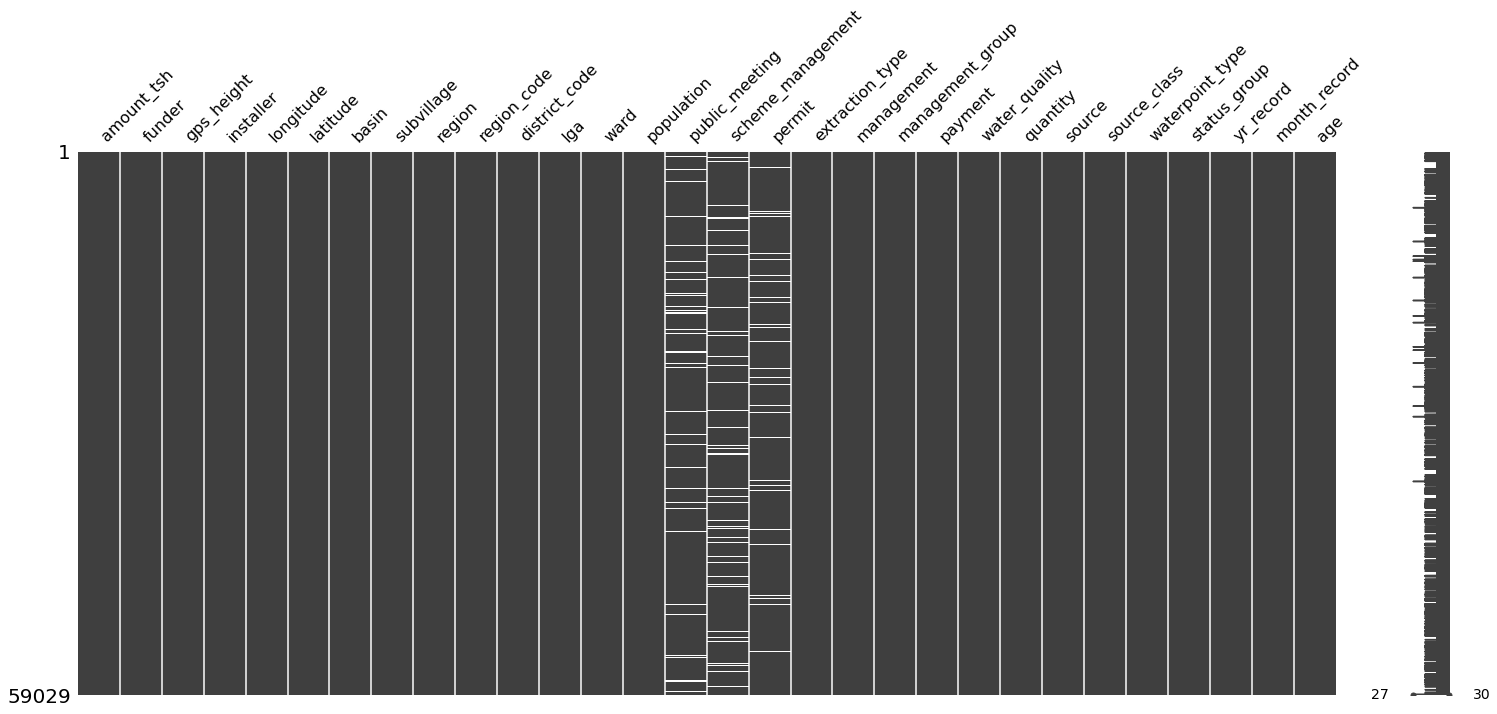

In [122]:
mssno.matrix(df_clean)

In [138]:
df_clean.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['gps_height', 'region_code', 'district_code', 'population'], dtype='object'),
 dtype('float64'): Index(['amount_tsh', 'longitude', 'latitude'], dtype='object'),
 dtype('O'): Index(['funder', 'installer', 'basin', 'subvillage', 'region', 'lga', 'ward',
        'public_meeting', 'scheme_management', 'permit', 'extraction_type',
        'management', 'management_group', 'payment', 'water_quality',
        'quantity', 'source', 'source_class', 'waterpoint_type',
        'status_group'],
       dtype='object')}

In [139]:
maybe_col_to_delete = [ 'recorded_by', 'funder', 'installer',  
                'lga', 'ward', 'region', 'scheme_management',
                 'wpt_name','scheme_name', 'extraction_type',
                 'extraction_type_group','management', 'payment_type', 
                 'quality_group', 'source_type', 'source', 
                 'waterpoint_type_group', 'quantity_group', 'subvillage']

In [140]:
cols_categorical = ['scheme_management','funder','installer', 'basin', 'subvillage',\
                    'region', 'lga', 'ward', 'extraction_type', 'management',\
                    'management_group', 'payment', 'water_quality',\
                    'quantity', 'source', 'source_class', 'waterpoint_type']
drop_cols          =[ 'funder','lga', 'ward', 'region',
                    'extraction_type','management','source']

In [141]:
df_clean.funder.value_counts().count()

84

In [142]:
df_clean = df_clean.drop(drop_cols,axis=1)


In [143]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59029 entries, 0 to 59399
Data columns (total 23 columns):
amount_tsh           59029 non-null float64
gps_height           59029 non-null int64
installer            59029 non-null object
longitude            59029 non-null float64
latitude             59029 non-null float64
basin                59029 non-null object
subvillage           59029 non-null object
region_code          59029 non-null int64
district_code        59029 non-null int64
population           59029 non-null int64
public_meeting       55696 non-null object
scheme_management    55160 non-null object
permit               55973 non-null object
management_group     59029 non-null object
payment              59029 non-null object
water_quality        59029 non-null object
quantity             59029 non-null object
source_class         59029 non-null object
waterpoint_type      59029 non-null object
status_group         59029 non-null int64
yr_record            59029 non-nu

In [145]:
#df_clean.select_dtypes(include=['float64', 'int64'])

# Variables with the Null Values
* There are only three variables in the clean dataset that have missing values. Based on the type of these variables we will use following strategies

### Binary Columns: 
   #### `public_meeting`:`permit`:
    * These two variables are binary with values **(True/False)**
    * Given that the proportion of null values are not too high for these variables, the null values will be replaced with the **most frequent**. 


### Categorical Columns:
   #### `schema_management`: 
       * There is no intrinsinc ordering to this variables, so the null values will be replaced with a **constant('missing')** creating its own level before one-hot encoding these variables. 


### Specify X and y:

In [146]:
X = df_clean.drop('status_group',axis=1)
y = df_clean.status_group

### Test-Train split the data:
- You should always split the data before applying any scaling/preprocessing techniques in order to avoid data leakage

In [147]:
#Default Train and Test data split of 75 and 25%
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,shuffle=True, stratify=y)

## Preprocessing Steps:

- **NA imputation** for ***binary,and categorical*** variables
    * For the binary/numerical variables, impute with the ***most frequent***.
    * For the categorical variables, impute with a constant: the string ***'missing'***. 
- **One-Hot-Encoding** for the ***categorical variables*** . 

In [148]:
def grab_numeric(df):
    return df.select_dtypes(exclude=[object])
GrabNumeric = FunctionTransformer(grab_numeric)

In [149]:
df_clean.select_dtypes(include=['object'])

,installer,basin,subvillage,public_meeting,scheme_management,permit,management_group,payment,water_quality,quantity,source_class,waterpoint_type
0,roman,Lake Nyasa,Mnyusi B,True,VWC,False,user-group,pay annually,soft,enough,groundwater,communal standpipe
1,other,Lake Victoria,Nyamara,NaN,Other,True,user-group,never pay,soft,insufficient,surface,communal standpipe
2,world vision,Pangani,Majengo,True,VWC,True,user-group,pay per bucket,soft,enough,surface,communal standpipe multiple
3,unicef,Ruvuma / Southern Coast,Mahakamani,True,VWC,True,user-group,never pay,soft,dry,groundwater,communal standpipe multiple
4,artisan,Lake Victoria,Kyanyamisa,True,NaN,True,other,never pay,soft,seasonal,surface,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...
59395,ces,Pangani,Kiduruni,True,Water Board,True,user-group,pay per bucket,soft,enough,groundwater,communal standpipe
59396,cefa,Rufiji,Igumbilo,True,VWC,True,user-group,pay annually,soft,enough,surface,communal standpipe
59397,other,Rufiji,Madungulu,True,VWC,False,user-group,pay monthly,fluoride,enough,groundwater,hand pump
59398,other,Rufiji,Mwinyi,True,VWC,True,user-group,never pay,soft,insufficient,groundwater,hand pump


In [151]:
#df_clean.select_dtypes(include=['float', 'int'])
#df_ana.select_dtypes(include=['float','int64'])
df_clean.select_dtypes(exclude=[object])

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,status_group,yr_record,month_record,age
0,6000.0,1390,34.938093,-9.856322,11,5,109,0,2011,3,15
1,0.0,1399,34.698766,-2.147466,20,2,280,0,2013,3,5
2,25.0,686,37.460664,-3.821329,21,4,250,0,2013,2,5
3,0.0,263,38.486161,-11.155298,90,63,58,1,2013,1,30
4,0.0,0,31.130847,-1.825359,18,1,0,0,2011,7,60
...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,37.169807,-3.253847,3,5,125,0,2013,5,15
59396,4700.0,1212,35.249991,-9.070629,11,4,56,0,2011,5,20
59397,0.0,0,34.017087,-8.750434,12,7,0,0,2011,4,60
59398,0.0,0,35.861315,-6.378573,1,4,0,0,2011,3,60


In [152]:
X_train.columns.to_series().groupby(df.dtypes).groups

{dtype('int64'): Index(['gps_height', 'region_code', 'district_code', 'population'], dtype='object'),
 dtype('float64'): Index(['amount_tsh', 'longitude', 'latitude'], dtype='object'),
 dtype('O'): Index(['installer', 'basin', 'subvillage', 'public_meeting',
        'scheme_management', 'permit', 'management_group', 'payment',
        'water_quality', 'quantity', 'source_class', 'waterpoint_type'],
       dtype='object')}

In [153]:
numeric_columns=['gps_height', 'region_code', 'district_code', 'population','amount_tsh',\
                 'longitude', 'latitude','yr_record','month_record','age']
#numeric_columns=['gps_height', 'population','amount_tsh',\
 #                'longitude', 'latitude']
cols_cat_binary = ['public_meeting','permit']
#cols_cat_missing = ['scheme_management]
cols_categorical = ['installer', 'basin', 'subvillage','scheme_management',
                    'management_group', 'payment', 'water_quality', 'quantity',
                    'source_class', 'waterpoint_type']
#cols_categorical =['scheme_management',]

In [154]:
X_train_binary  = X_train[cols_cat_binary]
X_train_cat     = X_train[cols_categorical]
X_train_numeric = X_train[numeric_columns]

print("X_train shape", X_train.shape)
print("binary shape", X_train_binary.shape)
print("cateogorical shape", X_train_cat.shape)
print("numeric shape", X_train_numeric.shape)

X_train shape (44271, 22)
binary shape (44271, 2)
cateogorical shape (44271, 10)
numeric shape (44271, 10)


In [184]:
preprocess_numeric = Pipeline(steps=[
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])

In [156]:
preprocess_binary = Pipeline(steps=[
    ('binary_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [157]:
preprocess_categorical= Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(sparse=False,handle_unknown='ignore'))
])

In [158]:
num_list=df_clean.columns.to_series().groupby(df.dtypes).groups

In [185]:
preprocessor = ColumnTransformer(transformers=
                                 [('preprocess_binary', preprocess_binary, cols_cat_binary),
                                  ('preprocess_categorical', preprocess_categorical,cols_categorical),
                                  ('preprocess_numeric',preprocess_numeric,numeric_columns)],
                                    remainder='passthrough')#,
                           #remainder='passthrough')

In [186]:
X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train))
X_train_transformed.shape

(44271, 16798)

In [178]:
X_test_transformed = pd.DataFrame(preprocessor.transform(X_test))
X_test_transformed

,0,1,2,3,4,5,6,7,8,9,...,16788,16789,16790,16791,16792,16793,16794,16795,16796,16797
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.966158,-0.815602,-0.070841,-0.374689,-0.099307,0.234771,-0.101214,-0.967896,-0.455427,1.219356
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.733660,-0.759222,-0.377380,0.035974,-0.099307,0.391107,0.831162,1.118670,-0.455427,-0.830866
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.082889,-0.251805,-0.479560,-0.372636,-0.099307,0.215066,-0.590488,-0.967896,-0.455427,-1.286471
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.059787,0.311991,-0.377380,0.356292,-0.091529,0.184190,0.360284,1.118670,-0.785171,-1.058668
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.839011,-0.646463,-0.479560,-0.372636,-0.099307,0.666512,0.259162,-0.967896,-0.455427,-1.058668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14753,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.966158,0.142852,2.483651,-0.374689,-0.099307,-0.487702,0.926336,-0.967896,0.863549,1.219356
14754,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.241603,-0.308185,-0.377380,-0.374689,2.389831,0.189109,-1.377172,1.118670,-0.785171,-0.603063
14755,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.966158,-0.646463,0.133518,-0.372636,-0.099307,0.560113,0.086981,-0.967896,-0.455427,-1.286471
14756,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.873808,-0.646463,-0.070841,-0.333623,-0.099307,0.696317,-0.035170,-0.967896,-0.455427,-1.286471


## Modeling Steps: 
- **preprocessing** as described above. 
- **class_weight** due to imbalanced target categories. 
- **estimator** is Random Forest. 

## Hyperparameter tuning:
- Use GridSearchCV to tune Hyperparameters.

## Scoring metric is F1_weighted:
* The goal is to impute null values for both classes as accurately as possible.
* We want to minimize both false positives (precision) and false negatives (recall) and we do not value either precision or recall more than the other.  
* The target variable is highly imbalanced so the harmonic mean of precision and recall is more meaningful.
* We also want to assign greater contribution to the class with more examples (1), so the weighted average is preferred.

### Baseline Model: Logistic Regression

In [187]:
#logreg_model_pipe = Pipeline(steps=[('ct', CT),
                            #('logreg', LogisticRegression(random_state=42))])
baseline_logreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator", LogisticRegression(random_state=42))])#,multi_class='multinomial', solver='newton-cg'))]) # use random state so that your model results are reproducable. 

# Train model
baseline_logreg.fit(X_train, y_train);

In [164]:
baseline_logreg.score(X_train, y_train)

0.7836506968444354

In [203]:
%load_ext autotime

time: 151 µs (started: 2023-01-03 11:34:55 -05:00)


In [208]:
baseline_logreg['preprocessor'].transformers_[0][1]

Pipeline(steps=[('binary_impute', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(handle_unknown='ignore', sparse=False,
                               sparse_output=False))])

time: 4.22 ms (started: 2023-01-03 11:35:57 -05:00)


In [209]:
cat_features_binary=baseline_logreg['preprocessor'].transformers_[0][1]\
    ['ohe'].get_feature_names_out(X_train_binary.columns)

time: 338 µs (started: 2023-01-03 11:37:20 -05:00)


In [210]:
#cat_feature_other = preprocessor.named_transformers_['preprocess_categorical'].named_steps['ohe'].get_feature_names_out(X_train_cat.columns)
cat_feature_other = baseline_logreg['preprocessor'].transformers_[1][1]\
    ['ohe'].get_feature_names_out(X_train_cat.columns)
feature_names     = np.r_[cat_features_binary, cat_feature_other,X_train_numeric.columns]
#feature_names = np.r_[X_not_cat.columns, cat_feature_names]
feature_names
X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns= feature_names)
X_train_transformed

,public_meeting_False,public_meeting_True,permit_False,permit_True,installer_acra,installer_adra,installer_africa,installer_aict,installer_amref,installer_angli,...,gps_height,region_code,district_code,population,amount_tsh,longitude,latitude,yr_record,month_record,age
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.974651,0.030093,-0.479560,-0.128291,-0.099307,-0.520954,0.595624,1.118670,-0.785171,-1.058668
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.966158,0.142852,-0.377380,-0.374689,-0.099307,-0.399301,1.384968,-0.967896,0.863549,1.219356
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.966158,-0.082666,-0.275200,-0.374689,-0.099307,-0.060999,0.088211,0.075387,2.182525,1.219356
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.009462,-0.308185,-0.479560,-0.372636,0.678548,0.438318,-1.899031,1.118670,-0.785171,-1.286471
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.839176,-0.477324,-0.377380,0.035974,-0.099307,0.764778,-0.382929,1.118670,-0.455427,-0.830866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44266,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.719244,0.255612,0.031339,0.651970,-0.099307,-0.026272,1.456781,0.075387,2.182525,-0.147458
44267,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.261984,-0.646463,-0.479560,-0.372636,-0.068193,0.638609,0.431862,-0.967896,-0.455427,0.535949
44268,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.598019,-0.646463,-0.479560,-0.372636,-0.099307,0.638981,0.352073,-0.967896,-0.455427,-0.147458
44269,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.966158,0.199232,-0.070841,-0.374689,-0.099307,-0.191452,1.058028,-0.967896,0.863549,1.219356


time: 5.99 s (started: 2023-01-03 11:38:18 -05:00)


In [301]:
#X_train_transformed['basin']
np.std(X_train)

amount_tsh        3213.964394
gps_height         693.009709
longitude            6.619076
latitude             2.955729
region_code         17.736889
district_code        9.786683
population         487.016729
public_meeting       0.286312
permit               0.461503
yr_record            0.958513
month_record         3.032656
age                 21.948841
dtype: float64

time: 2.6 s (started: 2023-01-04 20:13:12 -05:00)


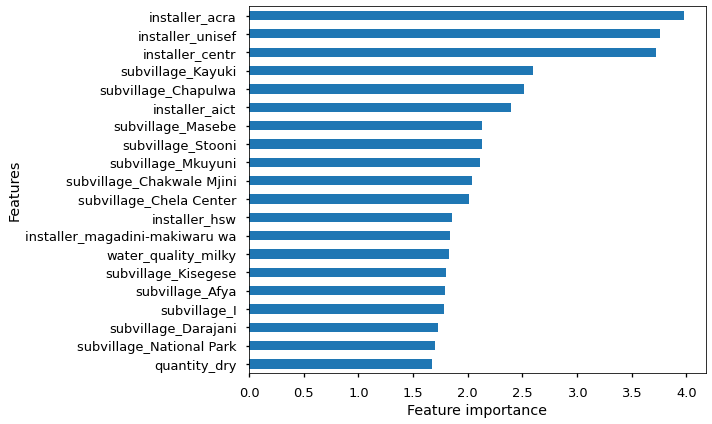

time: 202 ms (started: 2023-01-03 11:39:05 -05:00)


In [213]:
coeffs = baseline_logreg.named_steps['estimator'].coef_ 
importance = pd.Series(abs(coeffs[0]), index=feature_names) # logreg_coeffs[0] = getting the one-dim list inside the list
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(10,6))
    importance.sort_values().tail(20).plot.barh(ax=ax);        
    #ax.set_title("Relative Importance of Features \n for Predicting Vaccine Status \n ({}) \n".format(modelname), fontsize=18, fontweight='bold') 
    ax.set_xlabel('Feature importance')
    ax.set_ylabel('Features')
    fig.tight_layout()

In [ ]:
#y_test_preds  = baseline_logreg.predict(X_test)
#y_train_preds = baseline_logreg.predict(X_test)

In [ ]:
 with plt.style.context('seaborn-talk'):
        #fig, (ax1) = plt.subplots(figsize=(6, 5))
        #y_test_preds = baseline_logreg.predict(X_test)
        #cm = confusion_matrix(y_test, y_test_preds, labels=baseline_logreg.classes_)
        #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline_logreg.classes_)
        #disp.plot()
        #plt.show()
        

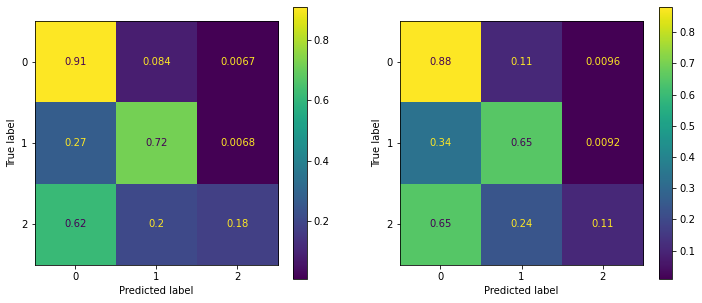

time: 9.71 s (started: 2023-01-03 12:34:19 -05:00)


In [256]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(baseline_logreg, X_train, y_train,normalize='true',ax=ax1)
ConfusionMatrixDisplay.from_estimator(baseline_logreg, X_test, y_test,normalize='true',ax=ax2)
plt.show()

In [282]:
#plot_roc_curve(baseline_logreg, X_train, y_train)#, ax=ax2, name ='Train ROC curve')
#roc_score_train_cv = cross_val_score(estimator=baseline_logreg, X=X_train,  y=y_train, 
#                                    cv=StratifiedKFold(shuffle=True)).mean()
#roc_score_train_cv

In [244]:
y_test_score  = baseline_logreg.predict_proba(X_test)
y_train_score = baseline_logreg.predict_proba(X_train)

time: 9.91 s (started: 2023-01-03 12:19:48 -05:00)


In [245]:
from sklearn.preprocessing import LabelBinarizer
n_classes = len(np.unique(y))
label_binarizer = LabelBinarizer().fit(y_train)
#y_onehot_test = label_binarizer.transform(y_test)
#y_onehot_test.shape  # (n_samples, n_classes)
colors = cycle(["aqua", "darkorange", "cornflowerblue"])

(14758, 3)

time: 8.58 ms (started: 2023-01-03 12:19:58 -05:00)


In [297]:
# This function plots confusion matrix (train) as well as roc_auc, recall, and precision scores

def model_evaluation_roc_auc(model):
    with plt.style.context('seaborn-talk'):
        fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12, 5))

        # Plot confusion matrix for the test set
        ConfusionMatrixDisplay.from_estimator(baseline_logreg, X_test, y_test,normalize='true',ax=ax1,cmap='Blues')
        ConfusionMatrixDisplay.from_estimator(baseline_logreg, X_train, y_train,normalize='true',ax=ax2,cmap='Blues')
        ax1.grid(False) 
        ax2.set_title("Confusion Matrix - Train")
        
        # plot Roc curve for the test and train
        #plot_roc_curve(model,X_test,y_test,ax=axs[1,0])
        #plot_roc_curve(model,X_train,y_train,ax=axs[1,1])
        plt.show()
        
        # Print classification Scores for the test set
        y_true = y_test
        y_pred = model.predict(X_test)
        divider = ('----' * 14) 
        table_title = 'Classification Report - Test:'
        table = classification_report(y_true, y_pred, digits=3)
        print('\n', divider, table_title, divider, table, divider, divider, '\n' , sep='\n') 
        
        # Print roc_auc for test and train 
        #roc_score_train_cv = cross_val_score(estimator=model, X=X_train,  y=y_train, 
                                        # cv=StratifiedKFold(shuffle=True), scoring='roc_auc').mean()
        roc_score_train = roc_auc_score(y_train, model.predict_proba(X_train),multi_class='ovr') 
        roc_score_test = roc_auc_score(y_test, model.predict_proba(X_test),multi_class='ovr')
        
        y_train_pred   = model.predict(X_train)
        y_test_pred    = model.predict(X_test)
        # Find F- Scores:
        recall_score_train = recall_score(y_train, y_train_pred, average='weighted')
        recall_score_test = recall_score(y_test, y_test_pred, average='weighted')
        
        # Print accuracy for test and train 
        acc_score_train = accuracy_score(y_train, y_train_pred) 
        acc_score_test = accuracy_score(y_test,   y_test_pred)
        
        #print(f" Mean Cross Validated Roc_Auc Score: {roc_score_train_cv :.2%}")    
        print(f" Train Roc_Auc Score: {roc_score_train :.2%}")  
        print(f" Test Roc_Auc Score: {roc_score_test :.2%}")    
        print('\n', divider, '\n' , sep='\n')
        
        print(f" Train Accuracy Score: {acc_score_train :.2%}")  
        print(f" Test Accuracy Score: {acc_score_test :.2%}")    
        print('\n', divider, '\n' , sep='\n')
        
        print(f" Train Sensitivity/Recall score: {recall_score_train :.2%}")    
        print(f" Test Sensitivity/Recall score: {recall_score_test :.2%}")  
        print('\n', divider, '\n' , sep='\n')
        
        
        print('Train Weighted Precision: {:.2f}'.format(precision_score(y_train, y_train_pred, average='weighted')))
        print('Test Weighted Precision: {:.2f}'.format(precision_score(y_test, y_test_pred, average='weighted')))
        
        

time: 840 µs (started: 2023-01-03 13:09:42 -05:00)


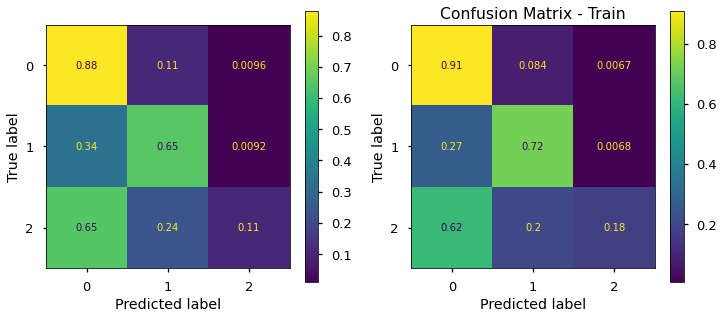



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.729     0.880     0.798      8014
           1      0.764     0.652     0.704      5665
           2      0.482     0.111     0.181      1079

    accuracy                          0.736     14758
   macro avg      0.658     0.548     0.561     14758
weighted avg      0.725     0.736     0.717     14758

--------------------------------------------------------
--------------------------------------------------------


 Train Roc_Auc Score: 89.11%
 Test Roc_Auc Score: 82.56%


--------------------------------------------------------


 Train Accuracy Score: 78.37%
 Test Accuracy Score: 73.65%


--------------------------------------------------------


 Train Sensitivity/Recall score: 78.37%
 Test Sensitivity/Recall score: 73.65%


--------------------------------------

In [290]:
model_evaluation_roc_auc(baseline_logreg)

In [295]:
def plot_roc_curve(model,X_test=X_test,y_test=y_test,ax=ax):
    y_onehot_test = label_binarizer.transform(y_test)
    y_score = model.predict_proba(X_test)
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")
    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
        )

    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend()

time: 585 µs (started: 2023-01-03 13:06:29 -05:00)


Micro-averaged One-vs-Rest ROC AUC score:
0.89
Micro-averaged One-vs-Rest ROC AUC score:
0.92


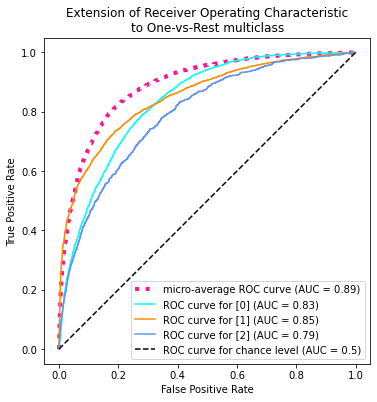

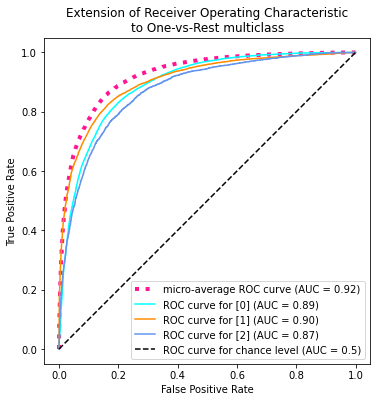

time: 9.8 s (started: 2023-01-03 13:06:47 -05:00)


In [296]:
plot_roc_curve(baseline_logreg,X_test,y_test)
plot_roc_curve(baseline_logreg,X_train,y_train)

* **GridSearch to find the best model**
* The Baseline model is already doing a pretty decent job to describe data. About 83%, 85% and 79% of classes are getting described accurately. Lets do a GridSearch now to find the best parameters for our Logistic Regression model

In [309]:
parameters = {
    'estimator__penalty' : ['l1','l2'], # default = l2 elasticnet is both
    'estimator__fit_intercept':[True, False],
    'estimator__C'       : [0.001,0.01,0.1,0.5,1,10,100], #np.logspace(-3,3,7) # default=1.0
    'estimator__solver'  : ['newton-cg', 'lbfgs', 'liblinear'], # default = ’lbfgs’
    'estimator__max_iter'  : [50,100,200,300]  # default = 100
}
      
# Create the grid, with "logreg_pipeline" as the estimator
best_logreg = GridSearchCV(estimator = baseline_logreg,   # model
                          param_grid = parameters,     # hyperparameters
                          #scoring ='roc_auc',          # metric for scoring
                          cv = 5,                      # number of folds for cross-validation
                          n_jobs = -1                  # 1 job per core of the computer.
)                      

# Train the pipeline (tranformations & predictor)
#best_logreg.fit(X_train, y_train);

time: 2.33 ms (started: 2023-01-06 12:48:12 -05:00)


In [375]:
rfc = RandomForestClassifier(random_state=42,class_weight = 'balanced')

rfc_model_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator",rfc)
])
rfc_model_pipe.fit(X_train, y_train);

In [378]:
knn = KNeighborsClassifier()
knn_model_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator",knn)
])
knn_model_pipe.fit(X_train, y_train);

In [ ]:
clf = XGBClassifier()
xgb_model_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator",clf)
])
xgb_model_pipe.fit(X_train, y_train);

In [239]:
dtree= DecisionTreeClassifier(random_state= 42)
dtree_model_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("estimator",dtree)
])
dtree_model_pipe.fit(X_train, y_train);


In [240]:
dtree_model_pipe.score(X_train, y_train)

0.985056640154254

In [241]:
xgb_model_pipe.score(X_train, y_train)

0.7685948421306339

In [242]:
baseline_logreg.score(X_train, y_train)

0.5768136900457942

In [243]:
#coeffs = baseline_logreg.best_estimator_.named_steps['estimator'].coef_ 
#importance = pd.Series((coeffs[0]), index=feature_names)
#importance.sort_values()

In [208]:
baseline_logreg.score(X_test, y_test)

0.5839780203889813

In [376]:
rfc_model_pipe.score(X_train, y_train)

0.9991618150103074

In [377]:
#y_preds=rfc_model_pipe.predict(X_test)
rfc_model_pipe.score(X_test, y_test)

0.7937478763166836

In [ ]:
rfc_model_pipe.classes_

In [205]:
knn_model_pipe.score(X_train, y_train)

0.7768136900457941

In [211]:
y_preds=knn_model_pipe.predict(X_test)
knn_model_pipe.score(X_test, y_preds)

1.0

In [258]:
#baseline_logreg.fit(X_train, y_train)

In [ ]:
rf_param_grid = {
    'n_estimators':[10,30,100],
    'criterion':['gini','entropy'],
    'max_depth':[None,2,6,10],
    'min_samples_split':[5,10],
    'min_samples_leaf':[3,6]
}

In [189]:
# Baseline model preprocessed and fit to a Random Forest Classifier
baseline_model_RF = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", RandomForestClassifier(random_state=42, class_weight = "balanced"))
])

# Hyperparameters used for model tuning
parameters = {
    'estimator__n_estimators': [150],                 # default=100 Number of trees.
    'estimator__criterion': ['entropy', 'gini'],      # default = gini
    'estimator__max_depth': [6, 7],                   # default = None, Lower depth prevents overfitting
    'estimator__max_features': [None, 5],             # default = None (n_features), Lower values prevent overfitting  
    'estimator__min_samples_split': [5, 10, 20],      # default = 2, Higher values prevent overfitting 
    'estimator__min_samples_leaf': [2, 4, 6]          # default = 1, Higher values prevent overfitting 
}   

# Create the grid, with "baseline_RF_insurance" as the estimator
best_model_RF = GridSearchCV(estimator = baseline_model_RF,   # model
                          param_grid = parameters,                    # hyperparameters
                          scoring ='f1_weighted',                     # metric for scoring
                          cv = 5,                                     # number of folds for cross-validation
                          n_jobs = -1                                 # 1 job per core of the computer.
)                      

# Train the pipeline (tranformations & predictor)
best_model_RF.fit(X_train, y_train);

In [190]:
best_model_RF.score(X_train,y_train)

0.6061365157520993

In [298]:
#coeffs = best_model_RF.best_estimator_.named_steps['estimator'].coef_ 
#best_model_RF.best_estimator_.named_steps['estimator'].coef_

#best_model_RF.named_steps['estimator']
#importance = pd.Series((coeffs[0]), index=feature_names)
#importance.sort_values()

time: 155 µs (started: 2023-01-03 13:10:44 -05:00)


In [231]:
best_model_RF.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocess_binary',
                                                  Pipeline(steps=[('binary_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [14, 16]),
                                                 ('preprocess_categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),

In [232]:
best_model_RF.best_estimator_.n_features_in_

29

In [195]:
best_model_RF.best_score_

0.6004662883852253

In [300]:
#model_evaluation_roc_auc(baseline_logreg)

In [ ]:
best_logreg.best_params_

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [145]:
#log_pipe = ModelWithCV(best_logreg, model_name='log_pipe', X=X_train, y=y_train)

In [146]:
#fig, ax = plt.subplots()
#log_pipe.plot_cv(ax=ax);

In [302]:
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

time: 330 ms (started: 2023-01-05 10:28:08 -05:00)


In [308]:
baseline_logreg.named_steps['estimator']

LogisticRegression(random_state=42)

time: 19.4 ms (started: 2023-01-06 12:46:42 -05:00)


In [312]:
baseline_logreg.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('preprocess_binary',
                                    Pipeline(steps=[('binary_impute',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ohe',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['public_meeting', 'permit']),
                                   ('preprocess_categorical',
                                    Pipeline(steps=[('cat_impute',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constan...
                                     'scheme_management', 'management_group',

time: 166 ms (started: 2023-01-06 13:22:46 -05:00)


In [313]:
from sklearn.feature_selection import SelectFromModel

time: 117 ms (started: 2023-01-07 21:11:20 -05:00)


In [ ]:
importance_f